# Imaging Performance Comparison (Flare)
This notebook loops over different noise levels and calibration errors to generate, corrupt, image, and compare solar flare datasets.

In [86]:
import fasr_solar_simul as fss
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.constants import c
import os
from casatasks import tclean, applycal, clearcal
from datetime import datetime
from pathlib import Path
from tqdm import tqdm

# Speed of light in m/s
C_LIGHT = c
import matplotlib
%matplotlib inline

In [87]:
from importlib import reload
reload(fss)
target = 'flare'

<module 'fasr_solar_simul' from '/Users/fisher/Library/Mobile Documents/com~apple~CloudDocs/work/research_project/ipynb_scripts_local/fasr_solar_simul.py'>

## Setup a Log Spiral Configuration

'generate_log_spiral_antenna_positions' completed at 2025-05-30 12:40:39; runtime: 0.00 seconds
fig saved to fig-fasr_Log_Spiral-168-n_arms=3-antennas_per_arm=56-alpha=1.00-gamma=0.55-r0=1.5-r_max=1800-n_turn=2.0.jpg
'plot_all_panels' completed at 2025-05-30 12:40:40; runtime: 0.70 seconds


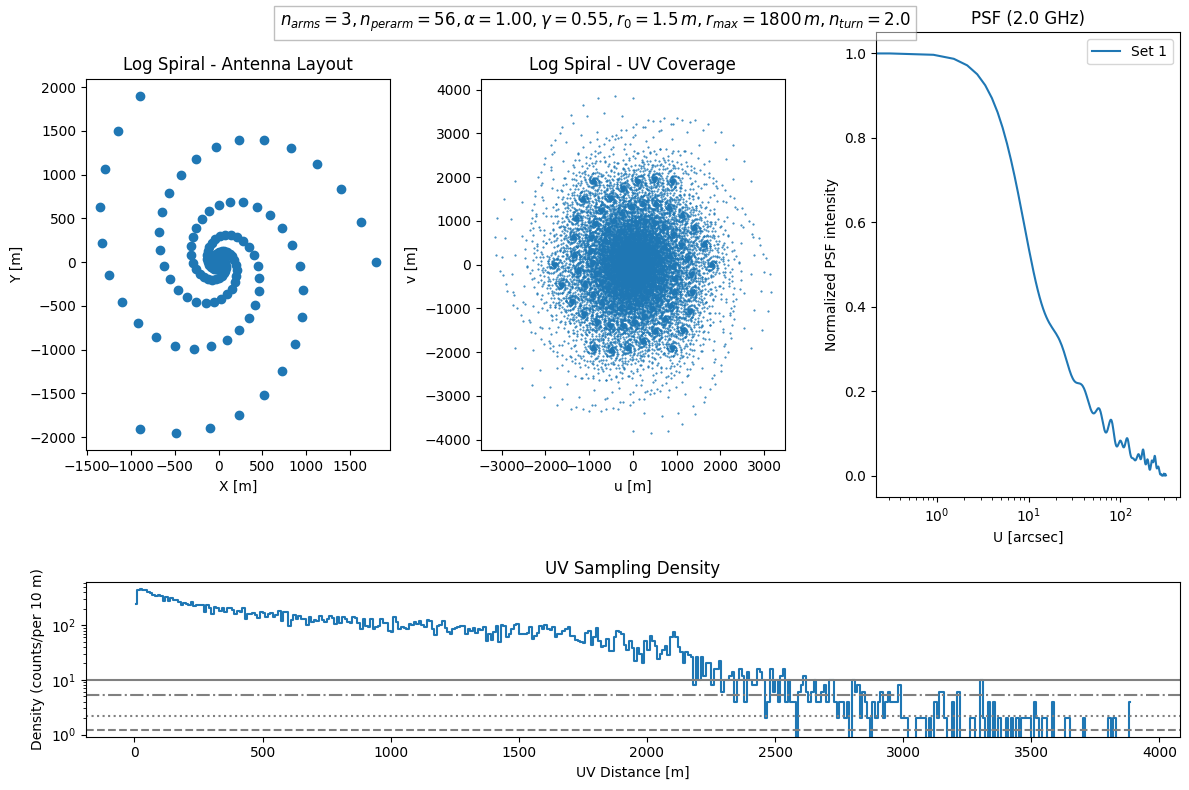

In [88]:
# %matplotlib notebook
%matplotlib inline
from importlib import reload

reload(fss)
# Define log-spiral parameters
array_config = {"n_arms": 3, "antennas_per_arm": 56, "alpha": 1.0, "gamma": 0.55, "r0": 1.5, "r_max": 1800, "n_turn": 2,
                "latitude": 35}

# for gam in np.linspace(0.3, 1, 8):
# array_config = {"n_arms": 3, "antennas_per_arm": 56, "alpha": 1.0, "gamma": gam, "r0": 1.5, "r_max": 1800, "n_turn": 2,
#                 "latitude": 35}
positions_logspiral = fss.generate_log_spiral_antenna_positions(**array_config)
figname = (
    f"fig-fasr_Log_Spiral-{len(positions_logspiral)}-"
    f"n_arms={array_config['n_arms']}-antennas_per_arm={array_config['antennas_per_arm']}-"
    f"alpha={array_config['alpha']:.2f}-gamma={array_config['gamma']:.2f}-"
    f"r0={array_config['r0']:.1f}-r_max={array_config['r_max']:.0f}-n_turn={array_config['n_turn']:.1f}.jpg")
print(f'fig saved to {figname}')
figsubfolder = figname.rstrip('.jpg')
formatted_params = [
    rf"$n_{{\rm arms}}={array_config['n_arms']}$",
    rf"$\mbox{{antennas per arm}}={array_config['antennas_per_arm']}$",
    rf"$\alpha={array_config['alpha']:.2f}$",
    rf"$\gamma={array_config['gamma']:.2f}$",
    rf"$r_0={array_config['r0']:.1f}\,\mbox{{m}}$",
    rf"$r_{{\rm max}}={array_config['r_max']:.0f}\,\mbox{{m}}$",
    rf"$n_{{\rm turn}}={array_config['n_turn']:.1f}$"
]

# Create a full string that also includes the spiral equation.
array_config_str = (
    rf"$n_{{arms}}={array_config['n_arms']}, "
    rf"n_{{perarm}}={array_config['antennas_per_arm']}, "
    rf"\alpha={array_config['alpha']:.2f}, \gamma={array_config['gamma']:.2f}, "
    rf"r_0={array_config['r0']:.1f}\,m, r_{{max}}={array_config['r_max']:.0f}\,m, "
    rf"n_{{turn}}={array_config['n_turn']:.1f}$"
)
fss.plot_all_panels(positions_logspiral, "Log Spiral", frequency=2, figname=figname,
                    array_config_str=array_config_str)


## Save the cfg file

In [ ]:
config_file = f"fasr_Log_Spiral-{len(positions_logspiral)}.cfg"
os.system('rm -rf ' + config_file)
fss.write_casa_antenna_list(config_file, positions_logspiral)

# Imaging Performance Comparison
looping over different noise levels and calibration errors to generate, corrupt, image, and compare solar targetflare datasets

## set up the simulation

In [118]:
# List of all available frequencies in GHz
freqlistALL = ['01.25GHz', '01.58GHz', '01.90GHz', '02.23GHz', '02.55GHz', '02.88GHz', '03.20GHz', '03.53GHz',
               '03.86GHz', '04.18GHz', '04.51GHz', '04.83GHz', '05.15GHz', '05.48GHz', '05.80GHz', '06.13GHz',
               '06.45GHz', '06.78GHz', '07.11GHz', '07.43GHz', '07.76GHz', '08.08GHz', '08.40GHz', '08.73GHz',
               '09.05GHz', '09.38GHz', '09.70GHz', '10.03GHz', '10.35GHz', '10.68GHz', '11.01GHz', '11.33GHz',
               '11.65GHz', '11.98GHz', '12.30GHz', '12.63GHz', '12.95GHz', '13.28GHz', '13.60GHz', '13.93GHz',
               '14.26GHz', '14.58GHz', '14.90GHz', '15.23GHz', '15.55GHz', '15.88GHz', '16.20GHz', '16.53GHz',
               '16.85GHz', '17.18GHz', '17.50GHz', '17.83GHz', ]

# List of configurations
project = 'FASR'
config_files = ['fasr_Log_Spiral-168.cfg', 'fasr-a-spiral-168-opt.cfg']

## Antenna temperature noise levels
noise_levels = ['0.005MK', '0.01MK'][:1]

## Define the fractional gain errors tuples: (phase and amplitude)
cal_errors = [(0.2, 0.2), (0.1, 0.1), (0.05, 0.05), (0.02, 0.02)]

# Select every 16th frequency for processing
freq_list = freqlistALL[::16]

# Reference timestamp for the observation series
reftime_obj = datetime(2017, 9, 10, 15, 45, 0)

# Flags to control overwriting existing data products
overwrite_ms   = False  # Overwrite measurement set?
overwrite_im   = False  # Overwrite image products?
overwrite_plot = False  # Overwrite existing plots?

# Deconvolution algorithm choice
deconvolver = 'hogbom'
# deconvolver = 'multiscale' ## this will be much slower than hogbom

# Imaging parameters (in seconds)
integration_time = 1  # Time per integration
duration         = 1  # Total imaging duration

## predict obs and image

Generated phase calibration table: caltb_FASR_corrupt_2pct.ph
Generated amplitude calibration table: caltb_FASR_corrupt_2pct.amp


2025-05-30 19:26:22	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2025-05-30 19:26:22	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-05-30 19:26:22	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-05-30 19:26:22	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


'plot_two_casa_images_with_convolution' completed at 2025-05-30 15:27:10; runtime: 0.74 seconds


2025-05-30 19:27:11	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2025-05-30 19:27:11	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-05-30 19:27:11	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-05-30 19:27:11	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


'plot_two_casa_images_with_convolution' completed at 2025-05-30 15:27:51; runtime: 0.45 seconds


2025-05-30 19:27:52	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2025-05-30 19:27:53	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-05-30 19:27:53	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-05-30 19:27:53	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


'plot_two_casa_images_with_convolution' completed at 2025-05-30 15:28:44; runtime: 0.71 seconds


2025-05-30 19:28:45	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2025-05-30 19:28:46	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-05-30 19:28:46	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-05-30 19:28:46	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


'plot_two_casa_images_with_convolution' completed at 2025-05-30 15:29:25; runtime: 0.43 seconds


2025-05-30 19:29:26	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2025-05-30 19:29:27	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-05-30 19:29:27	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-05-30 19:29:27	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


'plot_two_casa_images_with_convolution' completed at 2025-05-30 15:29:54; runtime: 0.40 seconds


2025-05-30 19:29:55	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2025-05-30 19:29:55	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-05-30 19:29:55	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-05-30 19:29:55	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


'plot_two_casa_images_with_convolution' completed at 2025-05-30 15:30:21; runtime: 0.44 seconds


2025-05-30 19:30:22	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2025-05-30 19:30:23	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-05-30 19:30:23	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-05-30 19:30:23	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


'plot_two_casa_images_with_convolution' completed at 2025-05-30 15:30:59; runtime: 0.57 seconds


2025-05-30 19:31:00	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2025-05-30 19:31:01	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Did not get the position of FASR from data repository
2025-05-30 19:31:01	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Please contact CASA to add it to the repository.
2025-05-30 19:31:01	WARN	SynthesisParamsImage::buildCoordinateSystem (file /Users/casaci/bamboohome/xml-data/build-dir/CASA-CRBC665PLUS0-BPOSX12PY310/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2940)	Using first antenna position as refence 


'plot_two_casa_images_with_convolution' completed at 2025-05-30 15:31:38; runtime: 0.45 seconds


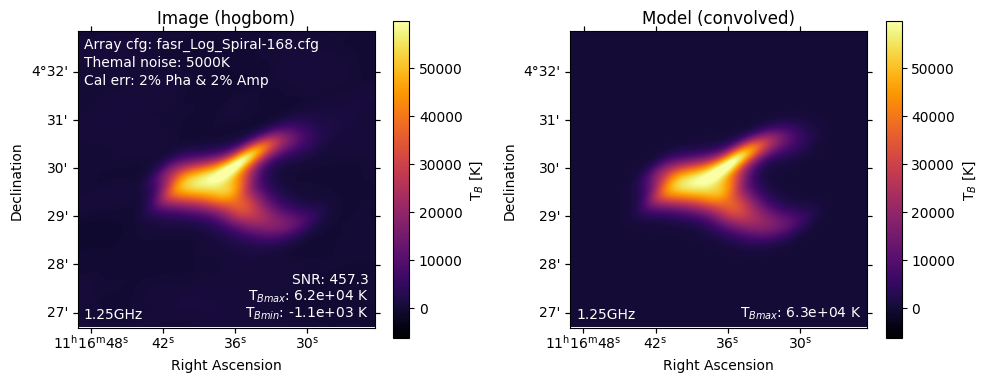

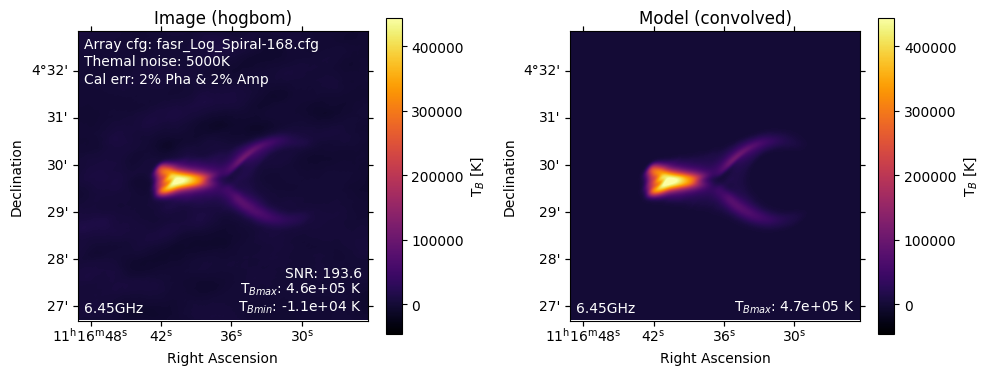

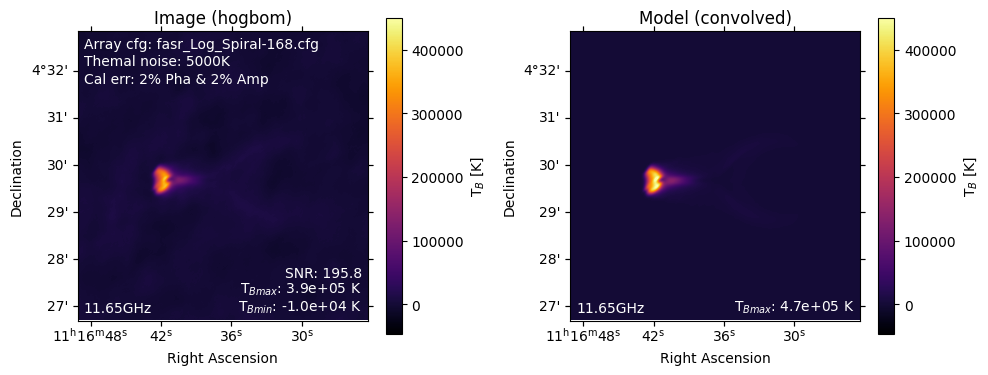

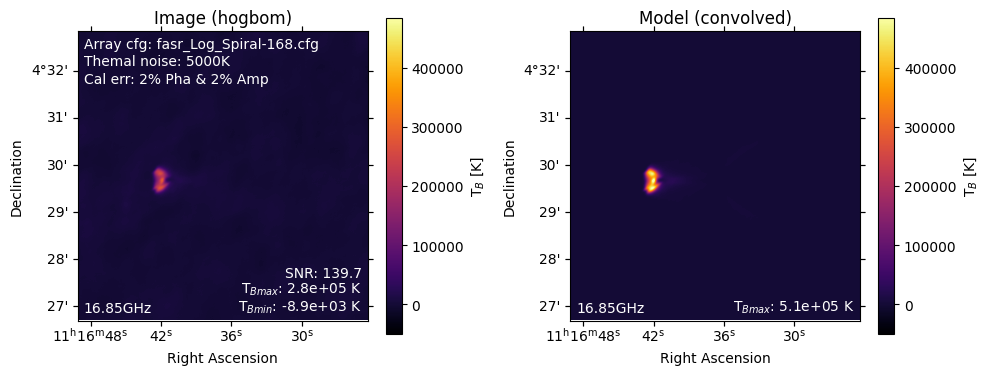

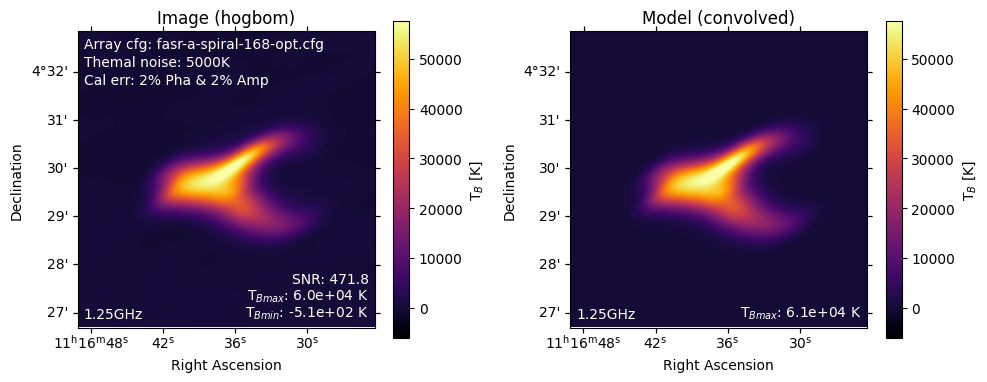

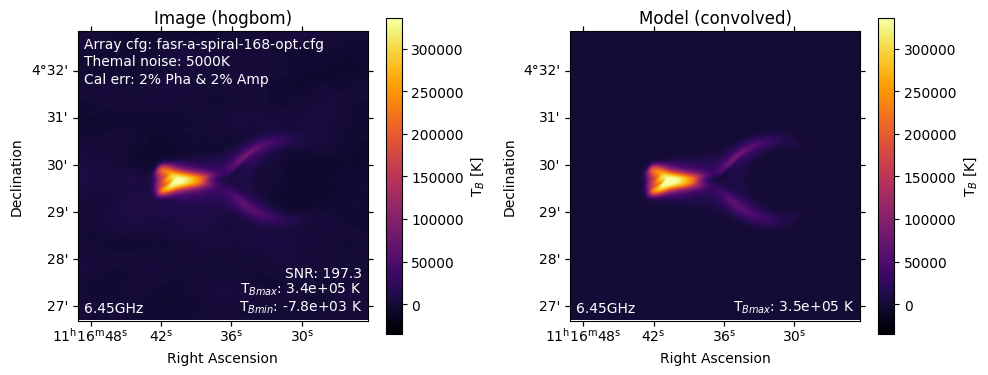

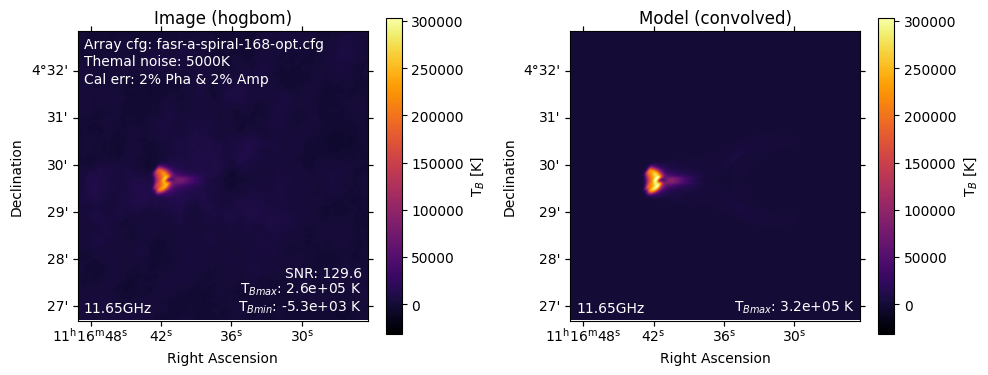

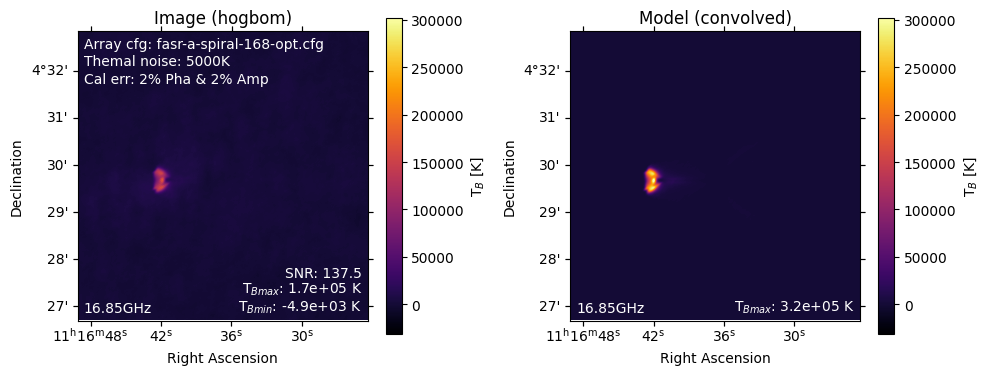

In [119]:
%matplotlib inline
reload(fss)

reftime = reftime_obj.strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder)
if not os.path.exists(figdir):
    os.makedirs(figdir)

for config_file in config_files:
    cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
    for freqstr in freq_list:
        solar_model = f'Eruptive_Flare/sep10_flare_cs_model.{freqstr}.I.fits'
        for noise in noise_levels:
            for phaerr, amperr in cal_errors:
                gaintable = [f'caltb_FASR_corrupt_{np.int_(phaerr*100)}pct.amp', f'caltb_FASR_corrupt_{np.int_(amperr*100)}pct.ph']
                msname = fss.make_msname(project,target, freqstr, reftime_obj, duration, integration_time, config_file, noise)
                imname = fss.make_imname(msname, deconvolver, phaerr, amperr)
                msfile = f'{msname}.ms'
                if os.path.exists(msfile):
                    if overwrite_ms:
                        os.system('rm -rf ' + msfile)
                    else:
                        pass

                if not os.path.exists(msfile):
                    fss.generate_ms(config_file, solar_model, reftime, freqstr, integration_time=integration_time,
                                    duration=duration,
                                    msname=msfile, noise=noise)

                if os.path.exists(f'{imname}.image'):
                    if overwrite_im:
                        junk = ['.image', '.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                        for j in junk:
                            os.system(f'rm -rf {imname}{j}')

                if not os.path.exists(f'{imname}.image'):
                    if not os.path.exists(gaintable[0]):
                        gaintable = fss.generate_caltb(msfile, caltype=['ph', 'amp'], calerr=[phaerr, amperr])
                    clearcal(vis=msfile)
                    applycal(vis=msfile, gaintable=gaintable, applymode='calonly', calwt=False)
                    tclean(vis=msfile, imagename=imname,
                           datacolumn='corrected',
                           field='', spw='', specmode='mfs', deconvolver=deconvolver,
                           imsize=2048, cell=['1.2arcsec'],
                           weighting='briggs', robust=-0.5,
                           niter=5000,
                           interactive=False)
                    junk = ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                    for j in junk:
                        os.system(f'rm -rf {imname}{j}')

                figname = os.path.join(figdir, f'fig-{os.path.basename(imname)}-blowup.jpg')
                if os.path.exists(figname):
                    if overwrite_plot:
                        os.system(f'rm -rf {figname}')

                if not os.path.exists(figname):
                    reload(fss)
                    ## cleaned image
                    image1 = imname + '.image'
                    ## model image
                    image2 = os.path.join(project, os.path.basename(solar_model.replace('.fits', '.im')))
                    ## meta information of the images
                    image_meta = {'title': [f'Image ({deconvolver})','Model (convolved)'],
                                  'freq': freqstr.lstrip("0"),
                                  'array_config': config_file,
                                  'noise': f'{1e6*float(noise.rstrip("MK")):.0f}K',
                                  'cal_error': f'{np.int_(phaerr*100)}% Pha & {np.int_(amperr*100)}% Amp',
                                  }

                    fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                                         crop_fraction=((0.85, 1.0), (0.35 + 0.02, 0.50 + 0.02)),
                                                                         figsize=(15, 4),
                                                                         image_meta=image_meta,
                                                                         cmap='inferno',
                                                                         vmax=95, vmin=-10,
                                                                         compare_two=False,
                                                                         contour_levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                                                                         conv_tag=f'.{cfg_suffix}',
                                                                         overwrite_conv=False)

                    fig.savefig(figname, dpi=300)

## plot imaging results and compare

plotting image1: FASR/fasr_flare_01.25GHz_20170910T154500UT_dur1s_int1s_fasr_Log_Spiral-168_noise0.005MK_phaerr20pct_amperr20pct_hogbom.image & image2 FASR/fasr_flare_01.25GHz_20170910T154500UT_dur1s_int1s_fasr-a-spiral-168-opt_noise0.005MK_phaerr20pct_amperr20pct_hogbom.image
'plot_two_casa_images' completed at 2025-05-30 15:34:25; runtime: 1.01 seconds
plotting image1: FASR/fasr_flare_01.25GHz_20170910T154500UT_dur1s_int1s_fasr_Log_Spiral-168_noise0.005MK_phaerr10pct_amperr10pct_hogbom.image & image2 FASR/fasr_flare_01.25GHz_20170910T154500UT_dur1s_int1s_fasr-a-spiral-168-opt_noise0.005MK_phaerr10pct_amperr10pct_hogbom.image
'plot_two_casa_images' completed at 2025-05-30 15:34:28; runtime: 1.30 seconds
plotting image1: FASR/fasr_flare_01.25GHz_20170910T154500UT_dur1s_int1s_fasr_Log_Spiral-168_noise0.005MK_phaerr5pct_amperr5pct_hogbom.image & image2 FASR/fasr_flare_01.25GHz_20170910T154500UT_dur1s_int1s_fasr-a-spiral-168-opt_noise0.005MK_phaerr5pct_amperr5pct_hogbom.image
'plot_two_ca

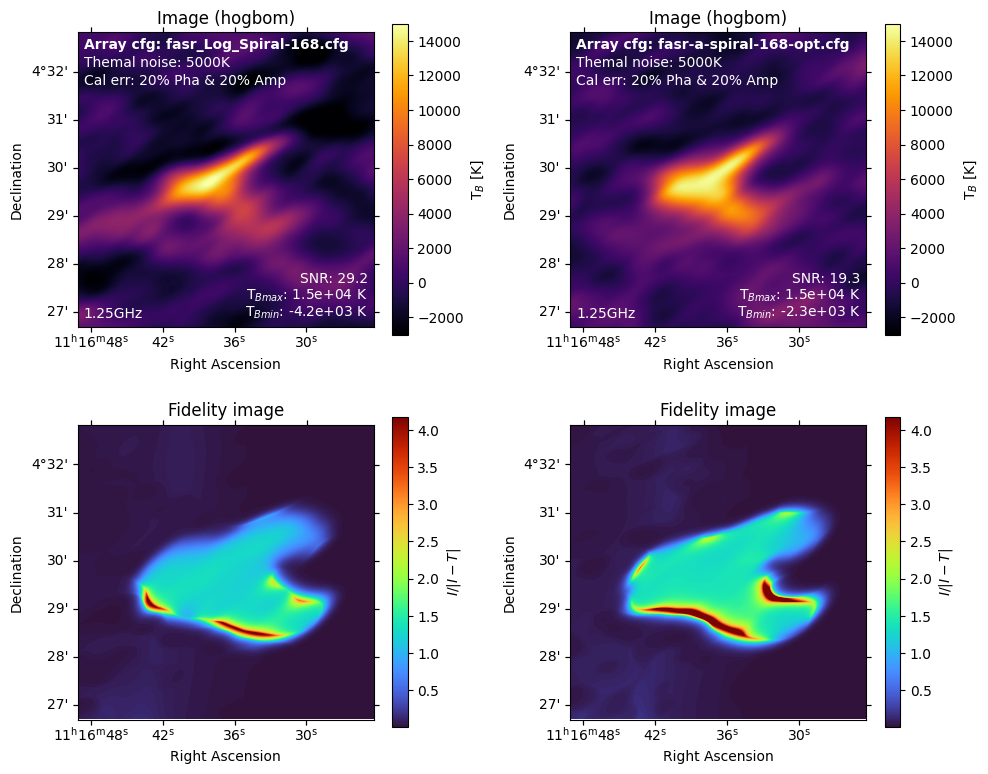

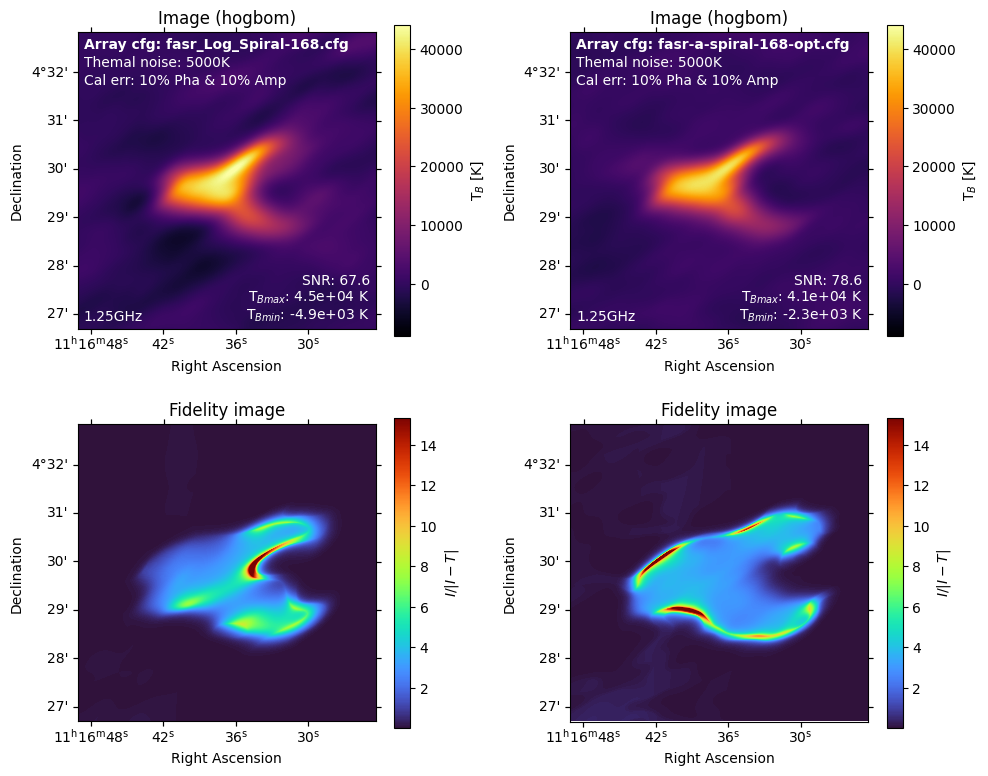

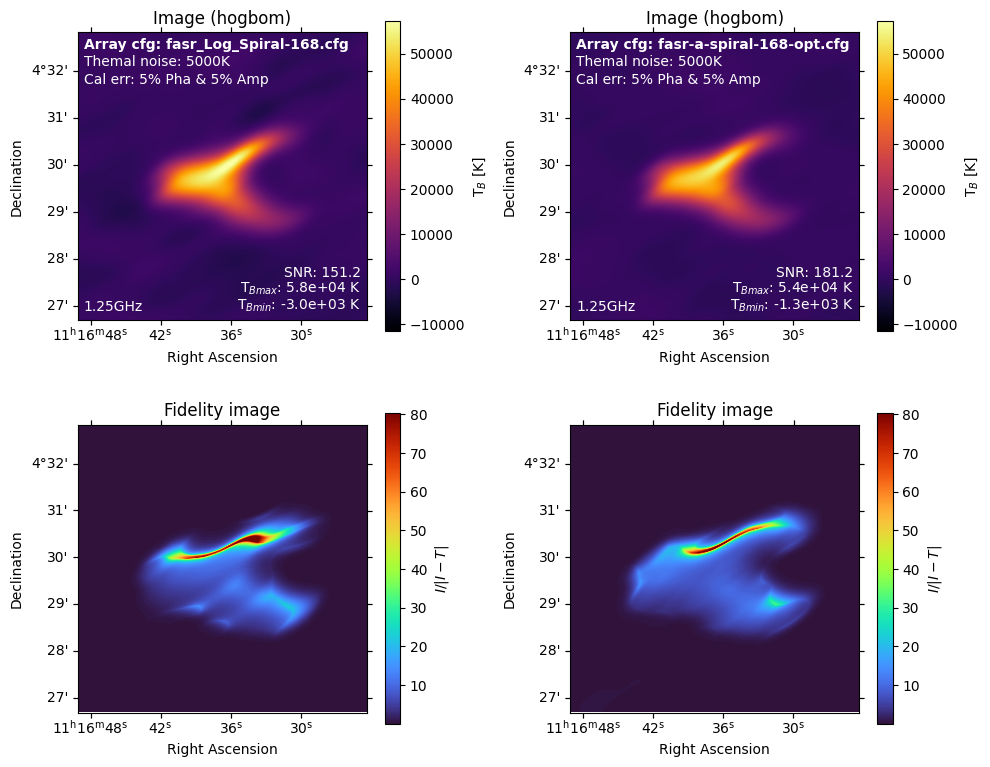

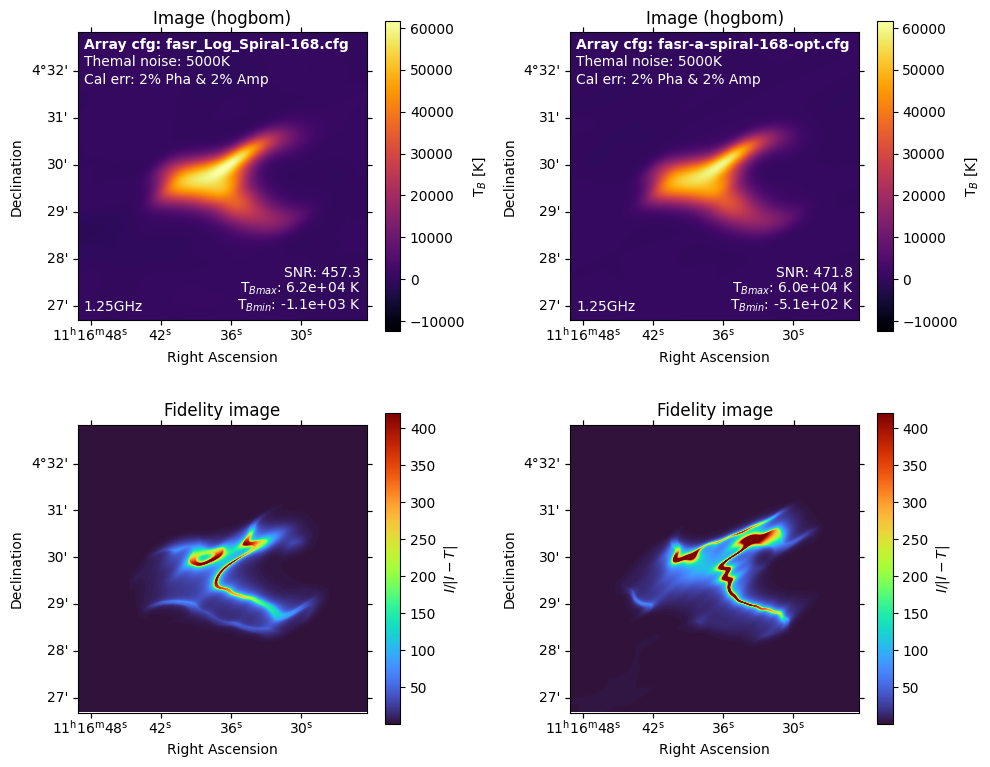

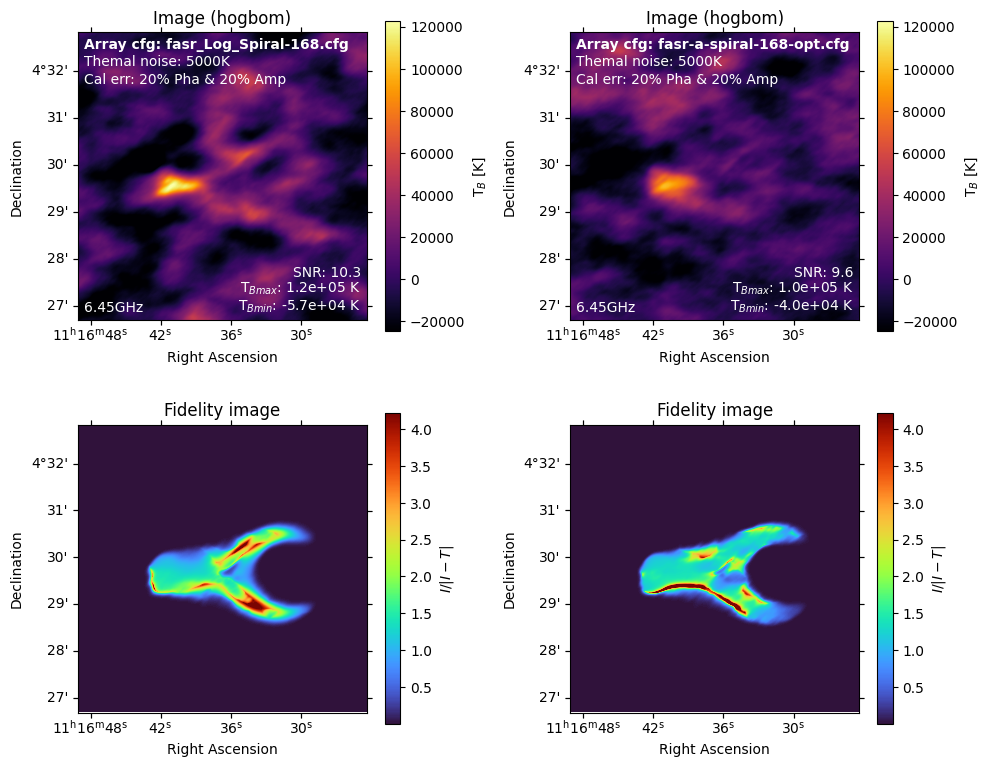

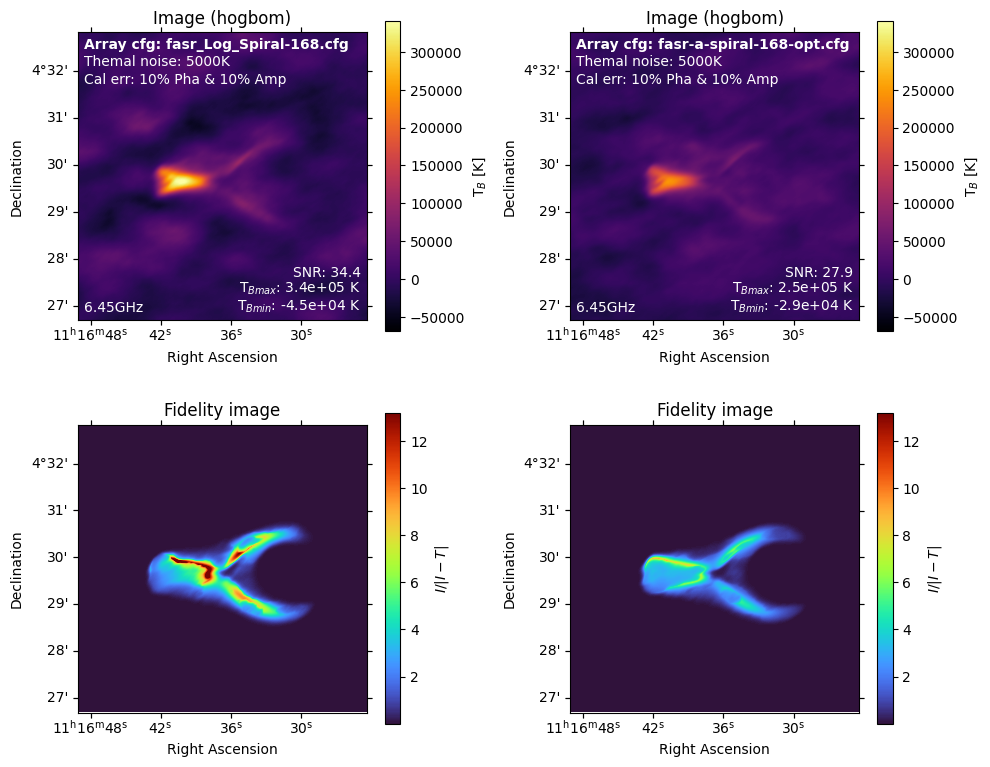

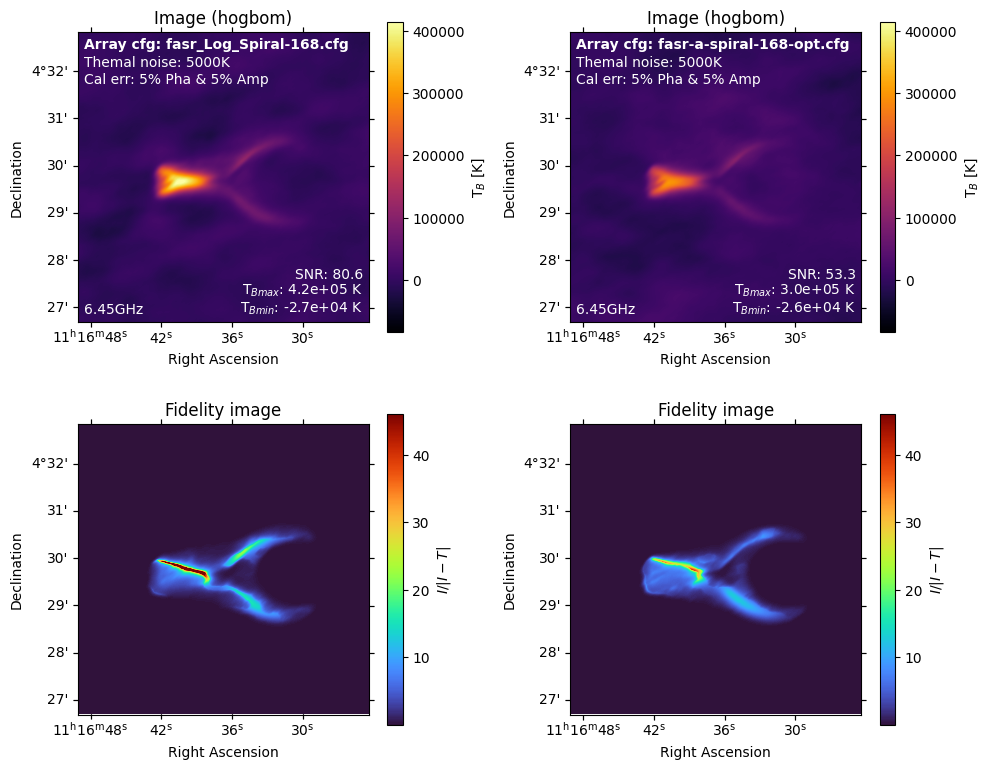

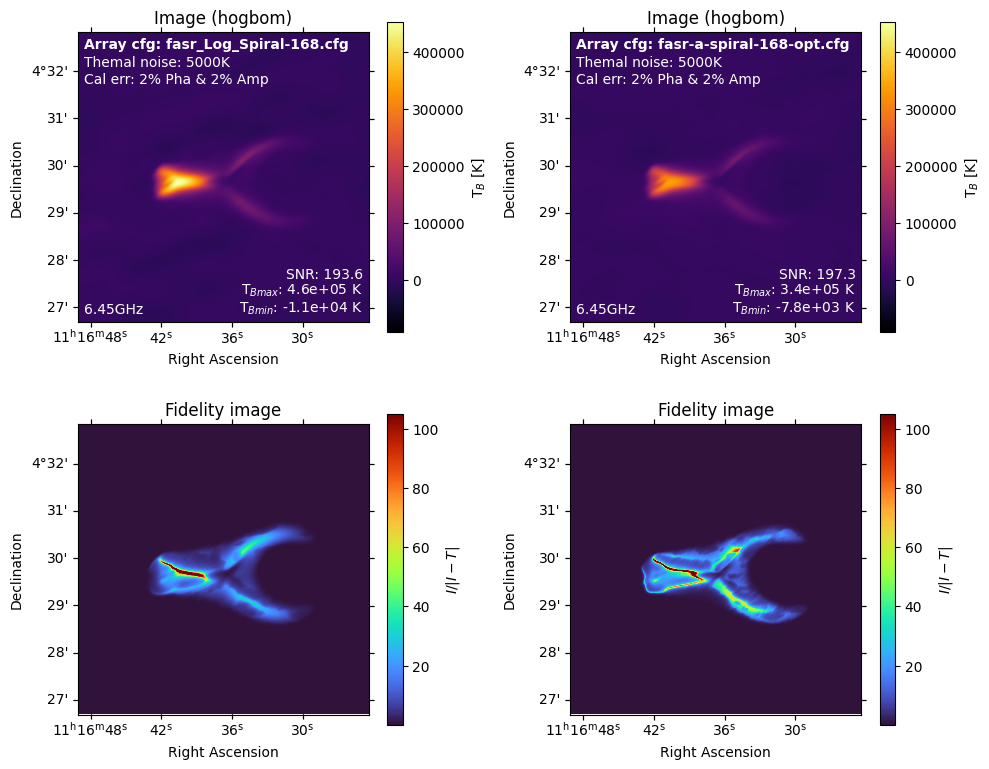

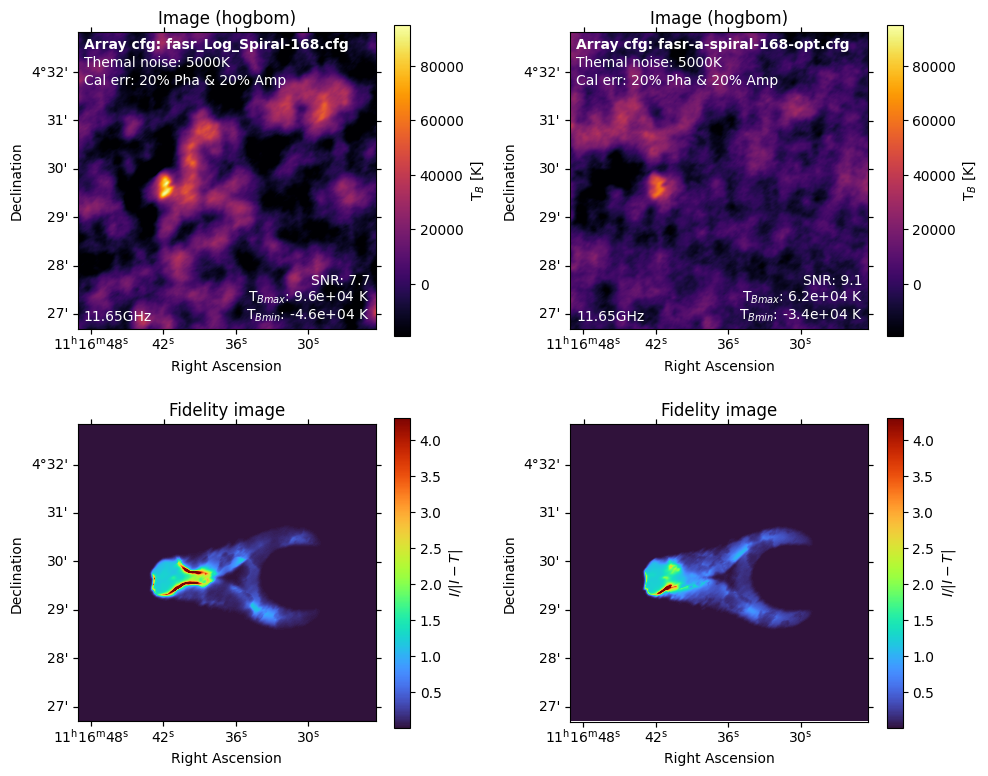

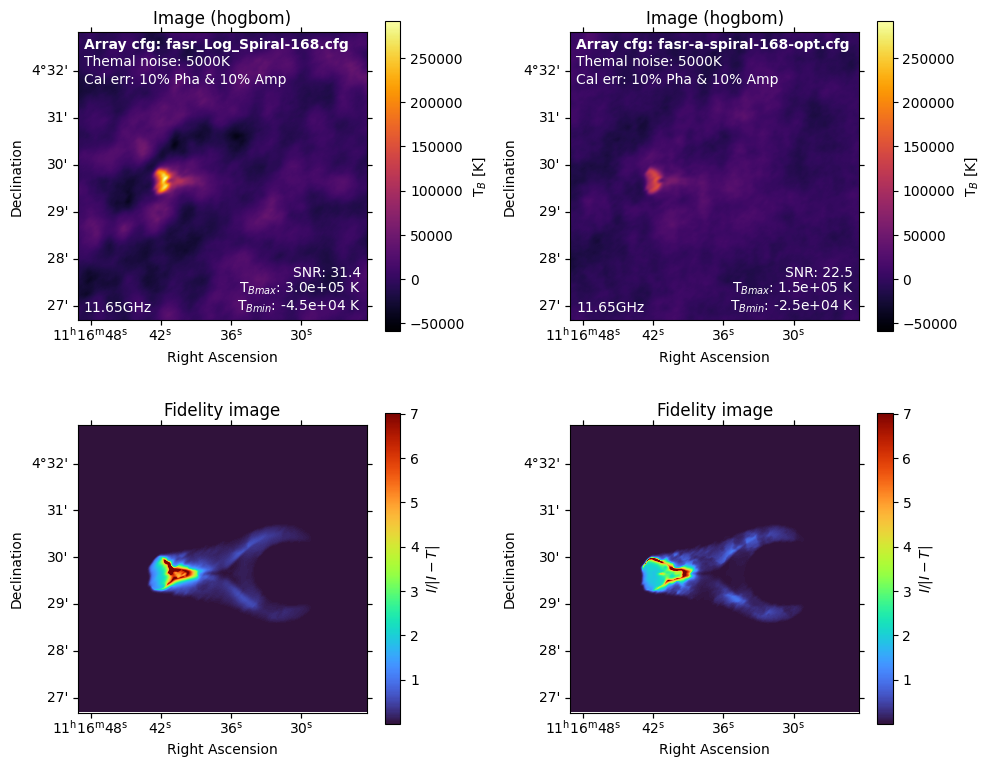

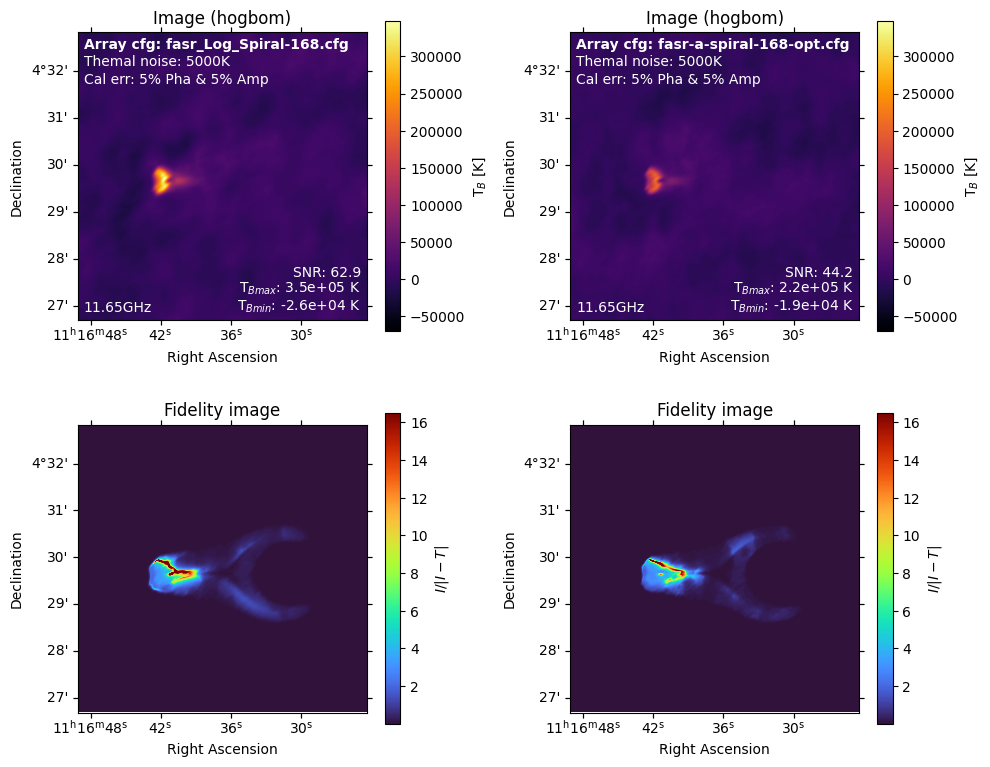

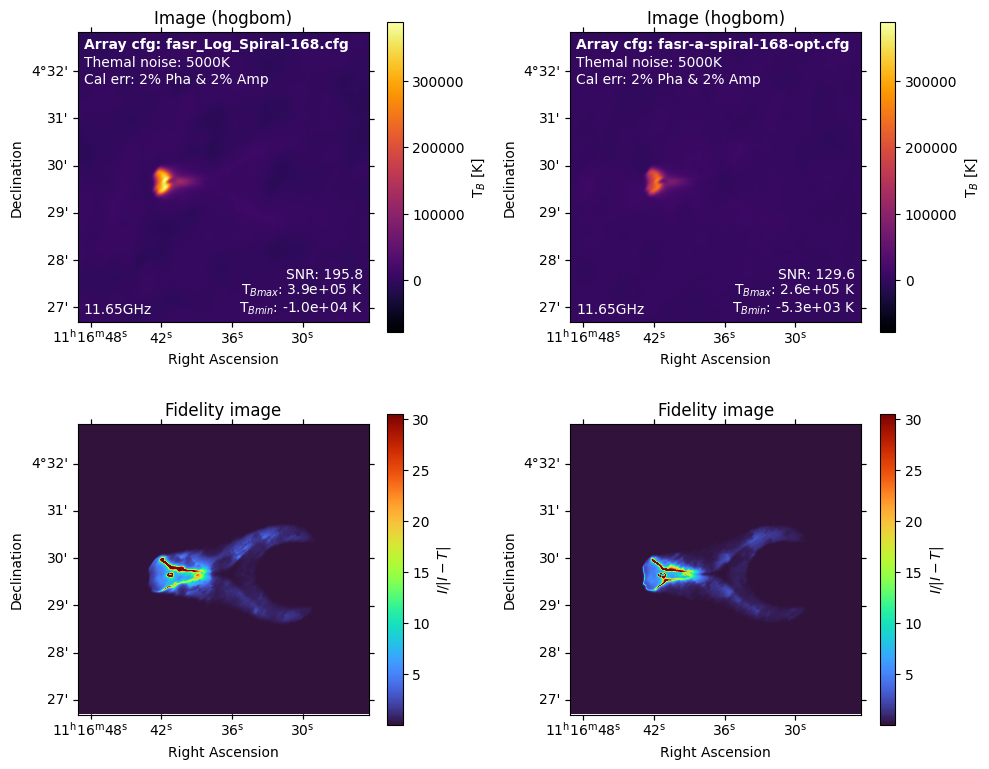

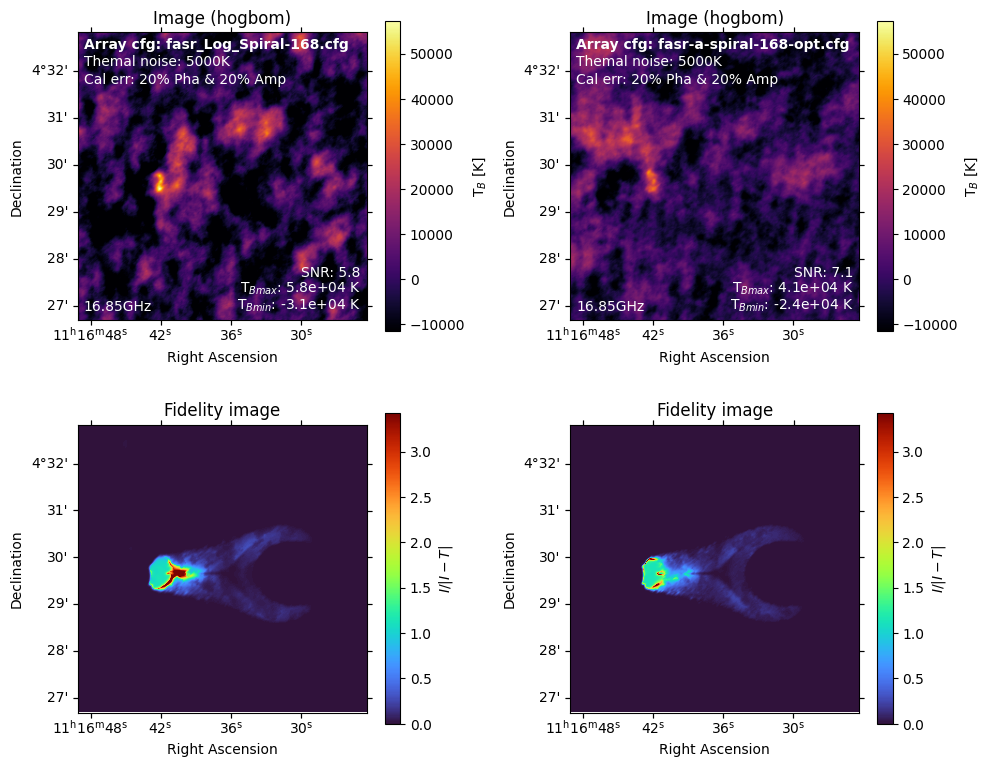

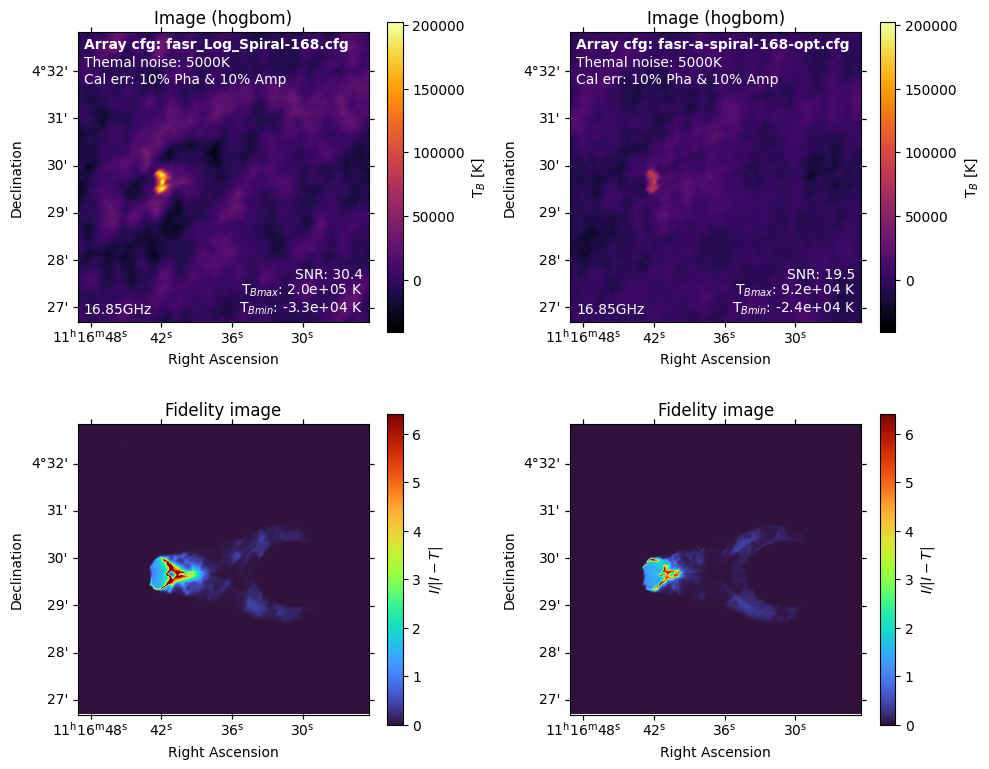

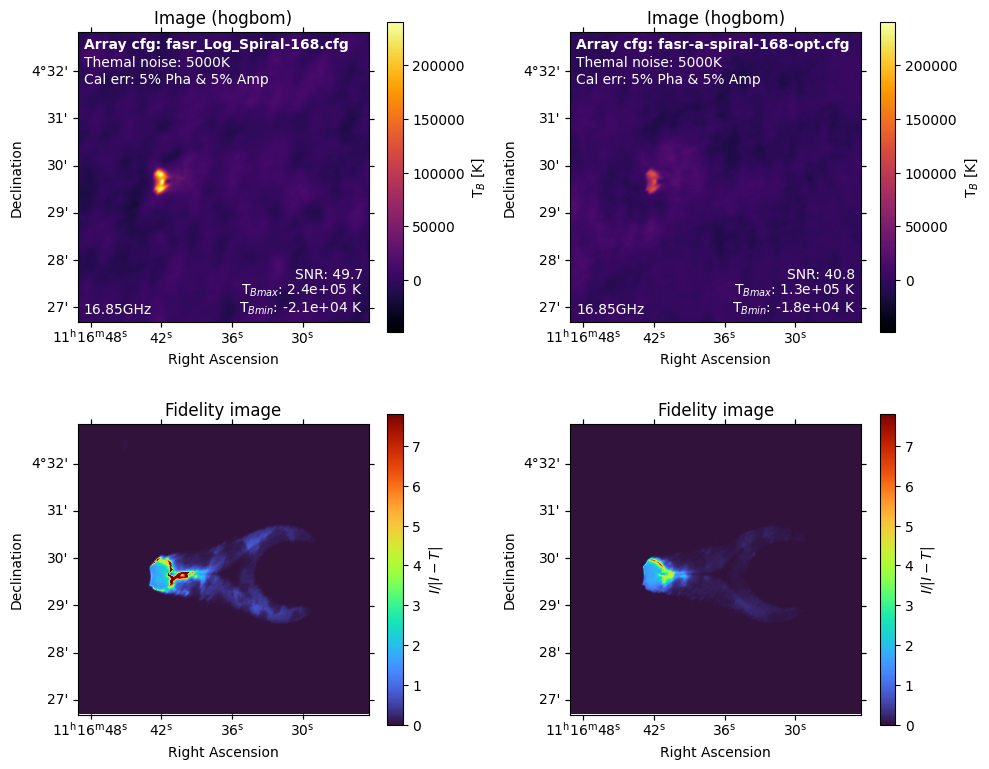

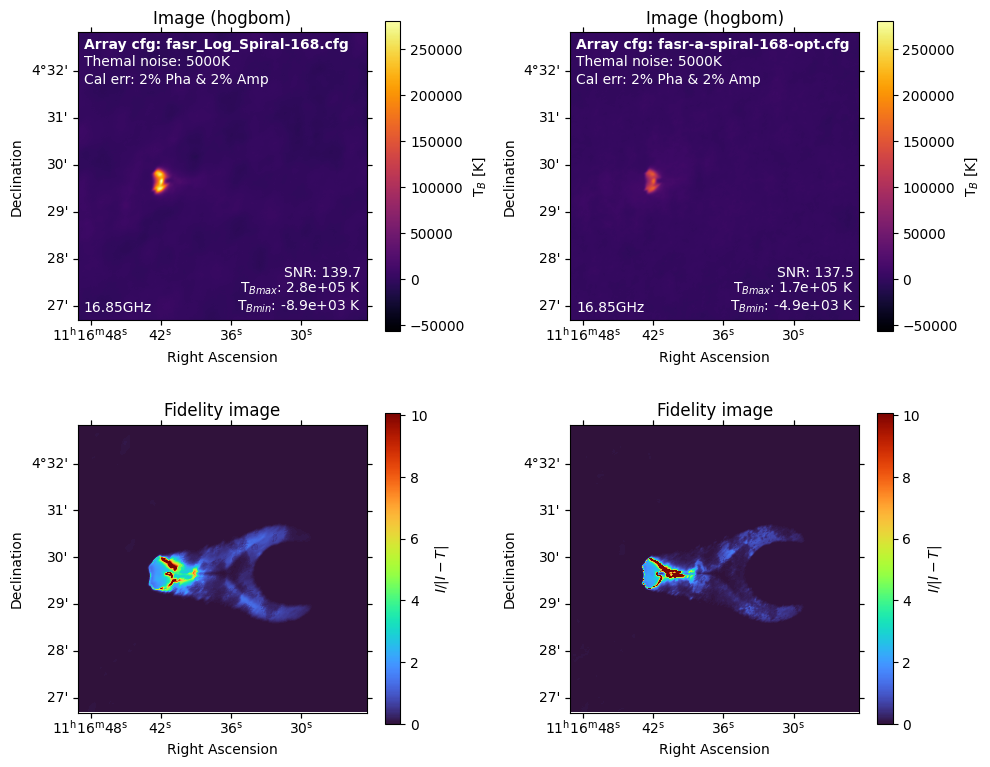

In [125]:
from importlib import reload
%matplotlib inline
reload(fss)
figdir = os.path.join(project, figsubfolder)
config_file1 = config_files[0]
cfg_suffix1 = os.path.basename(config_file1.rstrip(".cfg"))
config_file2 = config_files[1]
cfg_suffix2 = os.path.basename(config_file2.rstrip(".cfg"))

for freqstr in freq_list:
    solar_model = f'Eruptive_Flare/sep10_flare_cs_model.{freqstr}.I.fits'
    image1_model = os.path.join(project, os.path.basename(solar_model.replace('.fits', f'.{cfg_suffix1}.im.convolved')))
    image2_model = os.path.join(project, os.path.basename(solar_model.replace('.fits', f'.{cfg_suffix2}.im.convolved')))

    for noise in noise_levels:
        msname1 = fss.make_msname(project,target, freqstr, reftime_obj, duration, integration_time, config_file1, noise)
        msname2 = fss.make_msname(project,target, freqstr, reftime_obj, duration, integration_time, config_file2, noise)
        for phaerr, amperr in cal_errors:
            figname = os.path.join(figdir, f'fig-{target}_{cfg_suffix1}-vs-{cfg_suffix2}_noise{noise}_phaerr{np.int_(phaerr*100)}pct_amperr{np.int_(amperr*100)}pct-{deconvolver}-{freqstr}-img-fidelity-blowup.jpg')
            if os.path.exists(figname):
                if overwrite_plot:
                    os.system(f'rm -rf {figname}')

            if not os.path.exists(figname):
                imname1 = fss.make_imname(msname1, deconvolver, phaerr, amperr)
                image1 = imname1 + '.image'
                title1 = f'{freqstr} {cfg_suffix1} {deconvolver}'

                imname2 = fss.make_imname(msname2, deconvolver, phaerr, amperr)
                image2 = imname2 + '.image'
                title2 = f'{freqstr} {cfg_suffix2} {deconvolver}'
                print(f'plotting image1: {image1} & image2 {image2}')
                image_meta = {'title': [f'Image ({deconvolver})', f'Image ({deconvolver})'],
                              'freq': freqstr.lstrip("0"),
                              'array_config': config_files,
                              'noise': f'{1e6*float(noise.rstrip("MK")):.0f}K',
                              'cal_error': f'{np.int_(phaerr*100)}% Pha & {np.int_(amperr*100)}% Amp',
                              }

                fig, axs = fss.plot_two_casa_images(image1, image2,
                                                     crop_fraction=((0.85, 1.0), (0.35 + 0.02, 0.50 + 0.02)),
                                                     figsize=(10, 4),
                                                     image_meta=image_meta,
                                                     cmap='inferno',
                                                     cmap_model='turbo',
                                                     vmax=99, vmin=-20,
                                                     vmax_percentile=99.9, vmin_percentile=1,
                                                     uni_vmaxmin=True,
                                                     image1_model_filename=image1_model,
                                                     image2_model_filename=image2_model,
                                                     contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4, 0.8])

                fig.savefig(figname, dpi=300)